In [21]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from haversine import haversine_vector, Unit
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from common import geo_to_cartesian_m, cartesian_m_to_geo, fspl_distance, calculate_centroid_geo

In [22]:
df = pd.read_csv("data/mappers-mod-3-hotspot-all-fields-max-time-order-by-rssi.csv")
print(df.head())

                                     id   latitude   longitude   frequency  \
0  000000b6-d959-4a16-9ba6-972835f3da1a  44.305403  -96.806407  904.099976   
1  00000597-7025-41fd-a4fe-109ad16bf223  50.720951   -1.876882  868.299988   
2  00000756-6a55-4ca1-a8ff-fedf0c2f8449  36.144499  -86.792449  904.299988   
3  0000098c-6301-4638-81e4-00945299bf36  33.228809 -117.011214  904.299988   
4  000009ea-2b48-4e6f-8fb5-89a5d45b1113  36.146766  -86.795201  904.299988   

  spreading_factor  hotspot1_lat  hotspot1_long  hotspot1_rssi  hotspot1_snr  \
0         SF7BW125     44.304234     -96.780698         -117.0          -2.8   
1        SF10BW125     50.715620      -1.883604         -112.0         -12.0   
2         SF9BW125     36.152221     -86.791273          -85.0           7.2   
3         SF7BW125     33.302632    -116.852721         -100.0           4.8   
4         SF9BW125     36.196064     -86.850049         -106.0           0.2   

   hotspot2_lat  hotspot2_long  hotspot2_rssi  hot

In [23]:
# Limit data points to a specific region
lat_bounds = [37, 38]
long_bounds = [-124, -122]

df = df[df["latitude"] > min(lat_bounds)]
df = df[df["latitude"] < max(lat_bounds)]
df = df[df["longitude"] > min(long_bounds)]
df = df[df["longitude"] < max(long_bounds)]
for prefix in {"hotspot1", "hotspot2", "hotspot3"}:
    df = df[df[f"{prefix}_lat"] > min(lat_bounds)]
    df = df[df[f"{prefix}_lat"] < max(lat_bounds)]
    df = df[df[f"{prefix}_long"] > min(long_bounds)]
    df = df[df[f"{prefix}_long"] < max(long_bounds)]

In [24]:
N_HOTSPOTS = 3

In [25]:
# add dummy altitude for now
for hs_idx in range(1, N_HOTSPOTS + 1):
    df[f"hotspot{hs_idx}_altitude"] = 0

In [26]:
# if missing, add dummy frequency
if "frequency" not in df.columns:
    df["frequency"] = 915

In [27]:
# add cartesian coordinate variants
for hs_idx in range(1, N_HOTSPOTS + 1):
    df[[f"hotspot{hs_idx}_x_m", f"hotspot{hs_idx}_y_m", f"hotspot{hs_idx}_z_m"]] = geo_to_cartesian_m(
        lat_long_alt=df[[f"hotspot{hs_idx}_lat", f"hotspot{hs_idx}_long", f"hotspot{hs_idx}_altitude"]].to_numpy()
    )

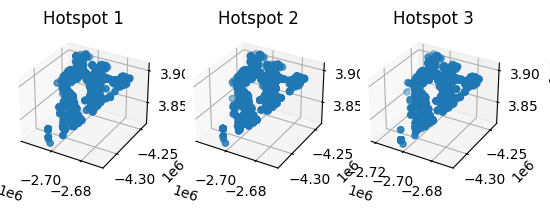

In [28]:
fig = plt.figure()
sub_df = df.sample(n=min(10000, len(df)))
for hs_idx in range(1, N_HOTSPOTS + 1):
    ax = fig.add_subplot(1, N_HOTSPOTS, hs_idx, projection='3d')
    ax.scatter(sub_df[f"hotspot{hs_idx}_x_m"], sub_df[f"hotspot{hs_idx}_y_m"], sub_df[f"hotspot{hs_idx}_z_m"])
    ax.set_title(f"Hotspot {hs_idx}")
plt.show()

In [29]:
for hs_idx in range(1, N_HOTSPOTS + 1):
    df[f"hotspot{hs_idx}_fspl_dist_km"] = fspl_distance(df[f"hotspot{hs_idx}_rssi"], df["frequency"])

In [30]:
# Add centroids
stacked_hs_lla = np.stack([ 
    df[[f"hotspot{hs_idx}_lat", f"hotspot{hs_idx}_long", f"hotspot{hs_idx}_altitude"]]
    for hs_idx in range(1, N_HOTSPOTS + 1)
], axis=0).swapaxes(0, 1) # n_samples, n_hs, 3

# centroid
projected_centroid_lat_long_alt = np.stack([calculate_centroid_geo(lat_long_alt=lla) for lla in stacked_hs_lla], axis=0)
projected_centroid_xyz_m = geo_to_cartesian_m(lat_long_alt=projected_centroid_lat_long_alt)
df[[
    "centroid_projected_x_m", "centroid_projected_y_m", "centroid_projected_z_m"
]] = projected_centroid_xyz_m
df[[
    "centroid_projected_lat", "centroid_projected_long", "centroid_projected_altitude"
]] = projected_centroid_lat_long_alt

In [31]:
# Add a naive tri/lat solve
def tri_lat_solve(distances_to_gateway, gateways_coordinates):
    def error(x, c, r):
        return sum([(np.linalg.norm(x - c[i]) - r[i]) ** 2 for i in range(len(c))])

    l = len(gateways_coordinates)
    S = sum(distances_to_gateway)
    # compute weight vector for initial guess
    W = [((l - 1) * S) / (S - w) for w in distances_to_gateway]
    # get initial guess of point location
    x0 = sum([W[i] * gateways_coordinates[i] for i in range(l)])
    # optimize distance from signal origin to border of spheres
    return minimize(
        error,
        x0,
        args=(gateways_coordinates, distances_to_gateway),
        method="Nelder-Mead",
    ).x


def tri_lat_apply_func(row):
    distances_to_gateway = []
    gateways_coordinates = [] 
    for hs_idx in range(1, N_HOTSPOTS + 1):
        distances_to_gateway.append(row[f"hotspot{hs_idx}_fspl_dist_km"])
        gateways_coordinates.append([
            row[f"hotspot{hs_idx}_x_m"],row[f"hotspot{hs_idx}_y_m"],row[f"hotspot{hs_idx}_z_m"],
        ])
    x,y,z = tri_lat_solve(distances_to_gateway, list(np.array(gateways_coordinates)))
    return [x,y,z]

tqdm.pandas()
df["naive_tri_xyz_m"] = df.progress_apply(tri_lat_apply_func, axis=1)
df["naive_tri_x_m"] = df["naive_tri_xyz_m"].map(lambda x : x[0])
df["naive_tri_y_m"] = df["naive_tri_xyz_m"].map(lambda x : x[1])
df["naive_tri_z_m"] = df["naive_tri_xyz_m"].map(lambda x : x[2])
df.pop("naive_tri_xyz_m")

# Calculate the error for the naive trilateration
df[[
    "naive_tri_lat", "naive_tri_long", "naive_tri_altitude"
]] = cartesian_m_to_geo(xyz_m=df[["naive_tri_x_m", "naive_tri_y_m", "naive_tri_z_m"]].to_numpy())

labels = df[["latitude", "longitude"]].to_numpy()
naive_pred = df[["naive_tri_lat", "naive_tri_long"]].to_numpy()
df["naive_tri_hav_err_km"] =  haversine_vector(array1=labels, array2=naive_pred, unit=Unit.KILOMETERS)

100%|██████████| 401507/401507 [24:04<00:00, 277.88it/s]


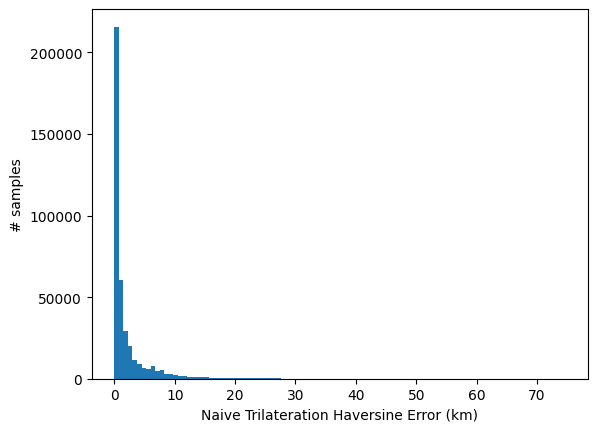

@ q=0.5,	 km=0.66km
@ q=0.9,	 km=6.33km
@ q=0.99,	 km=22.55km
@ q=0.995,	 km=30.71km
@ q=0.999,	 km=43.92km
@ q=0.9999,	 km=53.64km


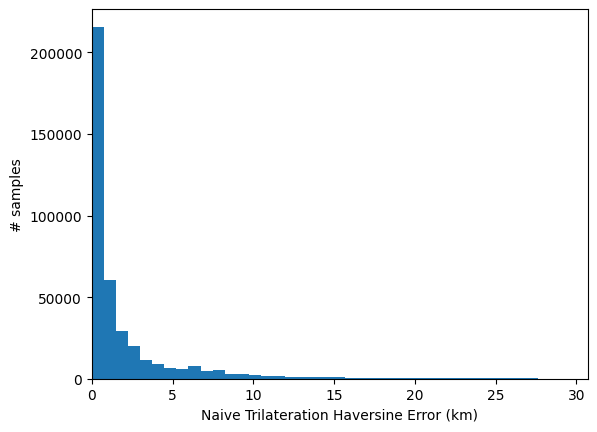

In [32]:
plt.hist(df["naive_tri_hav_err_km"], bins=100)
plt.ylabel("# samples")
plt.xlabel("Naive Trilateration Haversine Error (km)")
plt.show()

for q in [0.5, 0.9, 0.99, 0.995, 0.999, 0.9999]:
    km = np.quantile(df["naive_tri_hav_err_km"], q)
    print(f"@ q={q},\t km={km:.2f}km")
# zoom in
plt.figure()
plt.hist(df["naive_tri_hav_err_km"], bins=100)
plt.ylabel("# samples")
plt.xlabel("Naive Trilateration Haversine Error (km)")
plt.xlim(0, np.quantile(df["naive_tri_hav_err_km"], 0.995))
plt.show()


In [33]:
# re-format names
df = df.rename(columns={"latitude": "target_lat", "longitude": "target_long"})

# Add dummy altitude
df["target_altitude"] = 0

# Take only certain columns, the rest can be easily computed
out_cols = [
    'target_lat', 'target_long', 'target_altitude', 
    'frequency', #'spreading_factor',
    'hotspot1_lat', 'hotspot1_long', 'hotspot1_altitude', 'hotspot1_rssi', 'hotspot1_snr', 'hotspot1_fspl_dist_km',
    'hotspot2_lat', 'hotspot2_long', 'hotspot2_altitude', 'hotspot2_rssi', 'hotspot2_snr', 'hotspot2_fspl_dist_km',
    'hotspot3_lat', 'hotspot3_long', 'hotspot3_altitude', 'hotspot3_rssi', 'hotspot3_snr', 'hotspot3_fspl_dist_km',
    'centroid_projected_lat', 'centroid_projected_long', 'centroid_projected_altitude',
    'naive_tri_lat', 'naive_tri_long', 'naive_tri_altitude',
]
df = df[out_cols]

# Write out csv
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")
fpath = f"data/mappers_processed_{now_str}.csv"
df.to_csv(fpath, index=False)
print(f"File saved to {fpath}")

File saved to data/mappers_processed_20240204-192113.csv
